In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
from time import sleep

import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import clear_output

from utils.viz import viz 
viz.get_style()

## 0. Create a simple tabular maze environment

In [81]:
## Maze
class Maze:
	'''Reference: https://github.com/alversafa/option-critic-arch
	'''

	def __init__(self):
		layout = """\
wwwwwwwwwwwww
w     w     w
w  w  w     w
w  w        w
w       w   w
w       w   w
w           w
w     w    ww
w ww        w
w           w
w           w
w     w     w
wwwwwwwwwwwww
"""
		self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
		
		# Four possible actions
		# 0: UP
		# 1: DOWN
		# 2: LEFT
		# 3: RIGHT
		self.action_space = np.array([0, 1, 2, 3])
		self.observation_space = np.zeros(np.sum(self.occupancy == 0))
		self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

		self.rng = np.random.RandomState(2020)

		self.tostate = {}
		statenum = 0
		for i in range(13):
			for j in range(13):
				if self.occupancy[i,j] == 0:
					self.tostate[(i,j)] = statenum
					statenum += 1
		self.tocell = {v:k for k, v in self.tostate.items()}

		self.goal = 85
		self.init_states = list(range(self.observation_space.shape[0]))
		self.init_states.remove(self.goal)

	def render(self, show_goal=True):
		current_grid = np.array(self.occupancy)
		current_grid[self.current_cell[0], self.current_cell[1]] = -1
		if show_goal:
			goal_cell = self.tocell[self.goal]
			current_grid[goal_cell[0], goal_cell[1]] = -1
		return current_grid

	def reset(self):
		state = 30#self.rng.choice(self.init_states)
		self.current_cell = self.tocell[state]
		return state

	def check_available_cells(self, cell):
		available_cells = []

		for action in range(len(self.action_space)):
			next_cell = tuple(cell + self.directions[action])

			if not self.occupancy[next_cell]:
				available_cells.append(next_cell)

		return available_cells
		

	def step(self, action):
		'''
		Takes a step in the environment with 2/3 probability. And takes a step in the
		other directions with probability 1/3 with all of them being equally likely.
		'''

		next_cell = tuple(self.current_cell + self.directions[action])

		if not self.occupancy[next_cell]:

			if self.rng.uniform() < 1/3:
				available_cells = self.check_available_cells(self.current_cell)
				self.current_cell = available_cells[self.rng.randint(len(available_cells))]

			else:
				self.current_cell = next_cell

		state = self.tostate[self.current_cell]

		# When goal is reached, it is done
		done = state == self.goal


		return state, float(done), done, None

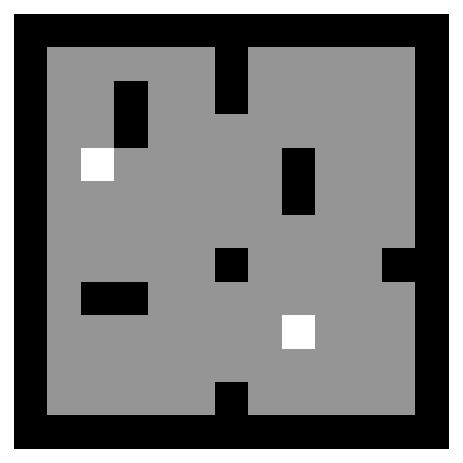

In [82]:
env = Maze()
env.reset()
# the task is to travel from the left white pixel to the right white pixel
clear_output(True)
plt.imshow(env.render(show_goal=True), cmap='Greys')
plt.axis('off')
plt.show()

In [119]:
def animation(maze, agent, maxStep=300, seed=2022):
    '''An animation of the agent behaviors

    Args: 
        maze:    environment 
        agent:   the trained agent 
        maxStep: the maximize allowed steps
        seed:    random seed
    '''
    rng = np.random.RandomState(seed)

    env = Maze()
    s = env.reset()
    step = 0 
    while True: 
        a = agent.get_act(s, rng)
        s, _, done, _ = env.step(a)
        step += 1 

        clear_output(True)
        plt.figure(figsize=(5, 5))
        plt.title(f'agent: {agent.name}, step: {step}', fontsize=20)
        plt.imshow(env.render(), cmap='Greys', )
        plt.axis('off')
        plt.show()

        if (done) or (step>=maxStep):
            break 


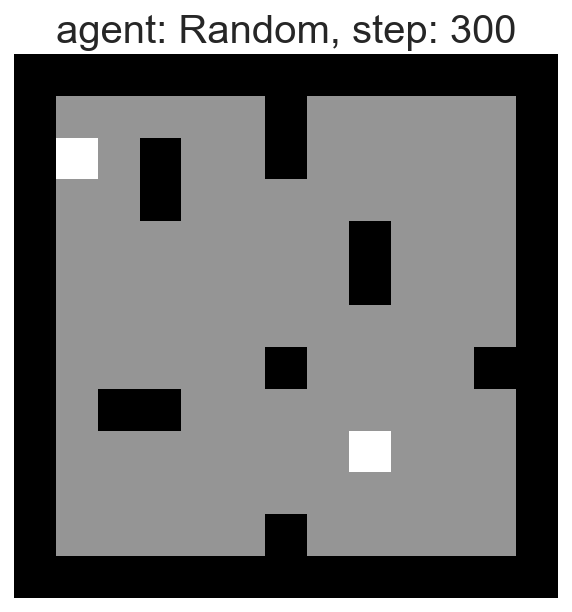

In [123]:
## A random agent 
class random:
    name = 'Random'

    def __init__(self, nS, nA, params=[]):
        self.nS = nS
        self.nA = nA
        self.load_params(params)

    def load_params(self, params):
        pass
    
    def get_act(self, s, rng):
        return rng.choice(self.nA)

env = Maze()
nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
Random_agent = random(nS, nA)
animation(Maze, Random_agent)

## 1. Sarsa

Pseudo code from (Sutton & Barto, 2018)

![Image](https://pic4.zhimg.com/80/v2-d9e5ab72791c3acc45055c1b32204622.png)

In [223]:
def train(maze, alg, params,
            maxStep=3_000, maxEpi=4_000, seed=2022):
    '''Train the agent

    Strictly follow the pseudo code shown above

    Args:
        maze:    the maze enviroment
        alg:     the RL algorithm 
        params:  parameters for the algorithm
        maxStep: the maximum allowed steps for each epsiode
        maxEpi:  the maximum allowed episode
        seed:    random seed for replication 
    
    Outputs:
        history: performance history
    '''
    # load environment, model, and init Q arbitrarily
    rng = np.random.RandomState(seed)
    env = Maze()
    nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
    agent = alg(nS, nA, params=params)
    agent.init_Q(rng,)

    # loop for each episode
    epi = 0
    history = np.zeros([maxEpi,]) + np.nan  # cache the algorithm performance in terms of steps
    for epi in range(maxEpi): 
        # initalize s 
        s = env.reset()
        # choose a from s using policy derived from Q 
        a = agent.get_act(s, rng)
        if agent.name == 'Sarsa, lambda':
            agent.reset()

        # loop for each step of episode
        steps = 0 
        while True:
            # observe r, s'
            s_next, r, done, _ = env.step(a)
            # choose a' from s' policy derived from Q 
            a_next = agent.get_act(s_next, rng)
            # update
            agent.update(s, a, r, s_next, a_next, done)
            # s <- s'; a <- a'
            s, a = s_next, a_next 
            steps += 1 
            # until s is terminal 
            if (done) or (steps>=maxStep):
                break 

        # cache the algorithm performance in terms of steps
        history[epi] = steps
        # simple moving average
        histforviz = pd.Series(history[:epi]).rolling(20
                    ).mean().values[20-1:]

        # plot performance
        if epi % 100 == 0:
            clear_output(True)
            plt.figure(figsize=(10,6))
            plt.title(f'Episode:{epi}')
            plt.xlabel('episodes')
            plt.ylabel('steps')
            plt.plot(histforviz, color=viz.Blue)
            plt.show()

    return history, agent
    

In [134]:
class Sarsa(random):
    name = 'Sarsa'

    def __init__(self, nS, nA, params):
        super().__init__(nS, nA, params) 
        
    def load_params(self, params):
        self.alpha = params[0]
        self.eps   = params[1]
        self.gamma = params[2]
         
    def init_Q(self, rng):
        '''Init Q(s,a) 

        As the pesudo code shown, init Q arbitrarily
        '''
        self.Q_sa = .1*rng.randn(self.nS, self.nA)

    def e_greedy(self, Q_sA, rng):
        '''Epsilon-greedy policy 

        Args:
            Q_sA: Q(s,_) the Q value for given state and
                all possible actions
            rng:  random state generator

        Output:
            a: an action 
        '''
        if rng.rand() < self.eps:
            a = rng.choice(range(self.nA)) 
        else: 
            a = np.argmax(Q_sA)
        return a 

    def get_act(self, s, rng):
        '''Sample an action from s policy derived from Q 
        '''
        Q_sA = self.Q_sa[s, :]
        return self.e_greedy(Q_sA, rng)

    def update(self, s, a, r, s_next, a_next, done):
        '''Update Q value 

        Q(s,a) <- Q(s,a) + α[r + γQ(s', a') - Q(s,a)]
        '''
        # Q(terminal, A) = 0 
        Q_next = 0 if done else self.Q_sa[s_next, a_next]
        # δ = r + γQ(s', a') - Q(s,a)
        delta = r + self.gamma*Q_next - self.Q_sa[s, a] 
        self.Q_sa[s, a] += self.alpha * delta     

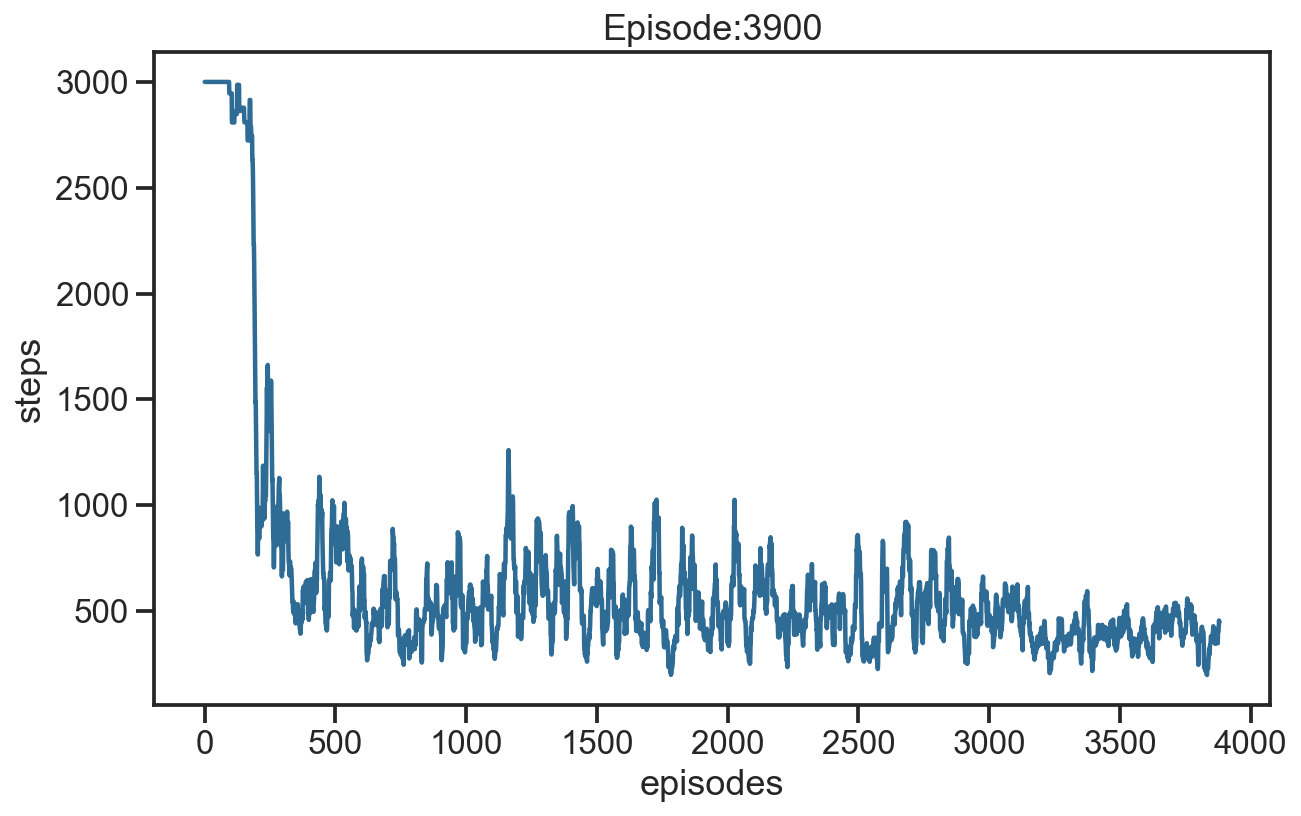

In [142]:
# alpha: step size, eps: epsilon for egreedy, gamma: discount factor 
params = [.01, .001, .99] 
Sarsa_hist, Sarsa_agent = train(Maze, Sarsa, params=params, seed=100)

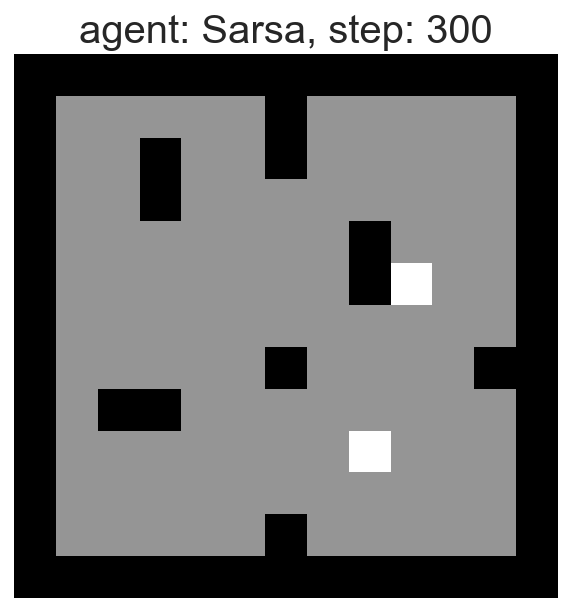

In [141]:
animation(Maze, Sarsa_agent)

## Sarsa feature: from tabular to one-hot feature

The second section of the Sutton & Barto's (2008) RL Bible discusses the RL with feature-based value approximators. Here we claim that tabular RL is equivalent to value approximators with the one-hot feature. Given this approximation, we can rewrite the Sarsa algorithm in the one-hot form. 

In [176]:
# x(s, a)
s, a = 2, 1
env = Maze()
nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
x = np.eye(nS*nA)[[nS*s+a], ].T
x.shape, x[nS*2+1]

((440, 1), array([1.]))

In [221]:
class Sarsa_oneHot(Sarsa):
    name = 'Sarsa, oneHot'

    def __init__(self, nS, nA, params):
        super().__init__(nS, nA, params) 

    def init_Q(self, rng):
        '''Init weight, w

        As the pesudo code shown, init Q arbitrarily
        '''
        self.w = (.1*rng.randn(self.nS*self.nA)).reshape([-1, 1])

    def get_act(self, s, rng):
        '''Sample an action from s policy derived from Q 
        '''
        Q_sA = self.w[list(range(s*self.nA, (s+1)*self.nA)),]    # nAxnS @ nSx1 = nAx1
        return self.e_greedy(Q_sA.reshape([-1]), rng)

    def phi(self, s, a=None):
        '''Return x(s,a)
        '''
        x = np.zeros([nS*nA, 1])
        x[s*self.nA+a, 0] = 1
        return x

    def update(self, s, a, r, s_next, a_next, done):
        '''Update Q value 

        w <- w + α[r + γw.T@x' - w.T@x]
        '''
        x      = self.phi(s, a)
        x_next = self.phi(s_next, a_next)
        Q_next = 0 if done else self.w.T@x_next # Q = x.T w 1xnA
        Q_curr = self.w.T@x         # 1xnA
        # δ = r + w.T@x' - w.T@x 
        delta = (r + self.gamma*Q_next - Q_curr)*x # nSx1 @ 1xnA
        self.w += self.alpha*delta     

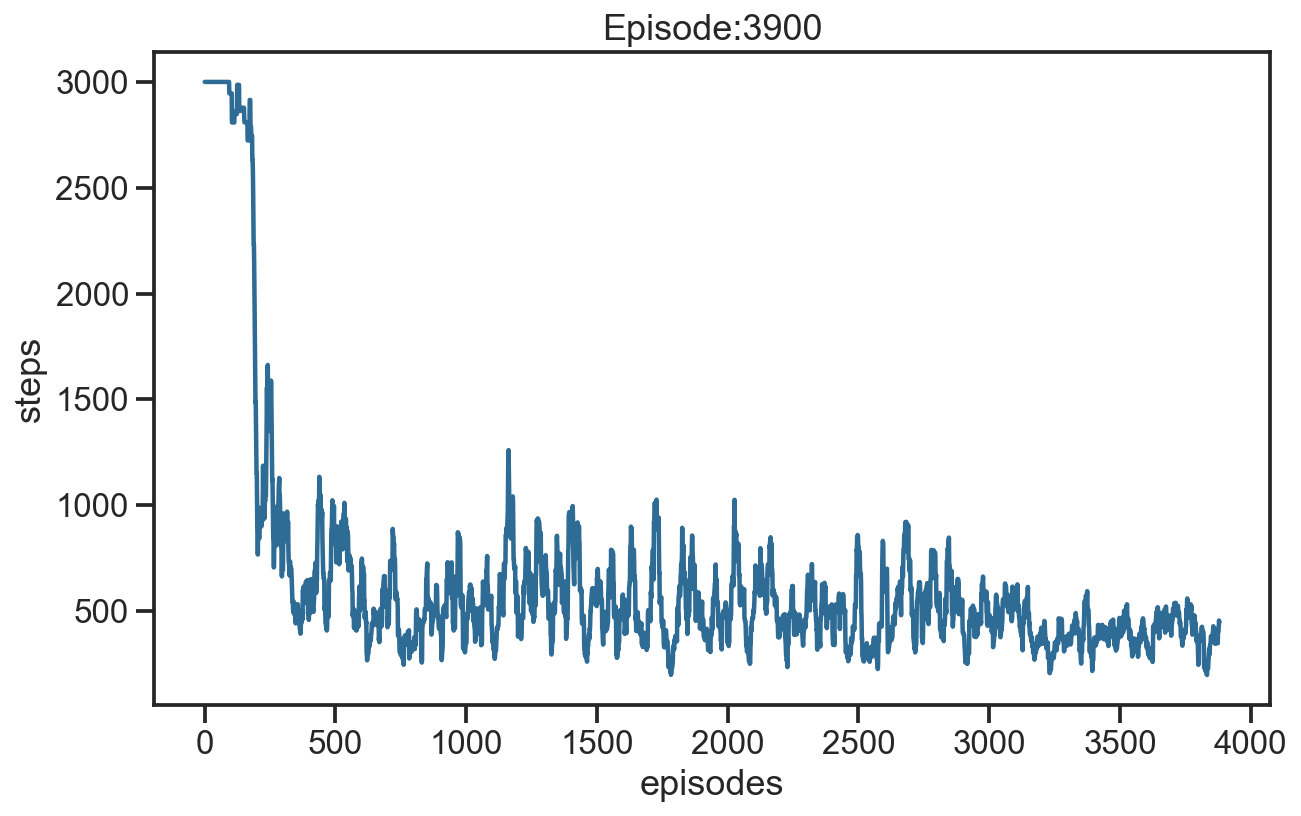

In [222]:
params = [.01, .001, .99] 
Sarsa_hist, Sarsa_agent = train(Maze, Sarsa_oneHot, params=params, seed=100)

## Sarsa(λ)

Once we had the feature-based Sarsa, we can implement the Sarsa(λ). The idea of algorithm is to add the momentoum 

![Image](https://pic4.zhimg.com/80/v2-23418c4533642bba1d05ea03705a1204.png)

In [229]:
class Sarsa_lambda(Sarsa):
    name = 'Sarsa, lambda'

    def __init__(self, nS, nA, params):
        super().__init__(nS, nA, params) 

    def load_params(self, params):
        self.alpha = params[0]
        self.eps   = params[1]
        self.gamma = params[2]
        self.lam   = params[3]

    def init_Q(self, rng):
        '''Init weight, w

        As the pesudo code shown, init Q arbitrarily
        '''
        self.w = (.1*rng.randn(self.nS*self.nA)).reshape([-1, 1])
    
    def reset(self):
        self.z = np.zeros([self.nS*self.nA, 1])
        self.Q_old = 0 

    def get_act(self, s, rng):
        '''Sample an action from s policy derived from Q 
        '''
        Q_sA = self.w[list(range(s*self.nA, (s+1)*self.nA)),]    # nAxnS @ nSx1 = nAx1
        return self.e_greedy(Q_sA.reshape([-1]), rng)

    def phi(self, s, a=None):
        '''Return x(s,a)
        '''
        x = np.zeros([nS*nA, 1])
        x[s*self.nA+a, 0] = 1
        return x

    def update(self, s, a, r, s_next, a_next, done):
        '''Update Q value 

        w <- w + α[r + γw.T@x' - w.T@x]
        '''
        x      = self.phi(s, a)
        x_next = self.phi(s_next, a_next)
        Q_next = 0 if done else self.w.T@x_next # Q = x.T w 1xnA
        Q_curr = self.w.T@x         # 1xnA
        # δ = r + w.T@x' - w.T@x 
        delta = (r + self.gamma*Q_next - Q_curr)*x # nSx1 @ 1xnA
        self.z = self.gamma*self.lam*self.z + \
            (1 - self.alpha*self.gamma*self.lam*self.z.T@x)*x
        self.w += self.alpha*(delta + Q_curr - self.Q_old)*self.z \
            - self.alpha*(Q_curr - self.Q_old)*x
        self.Q_old = Q_next

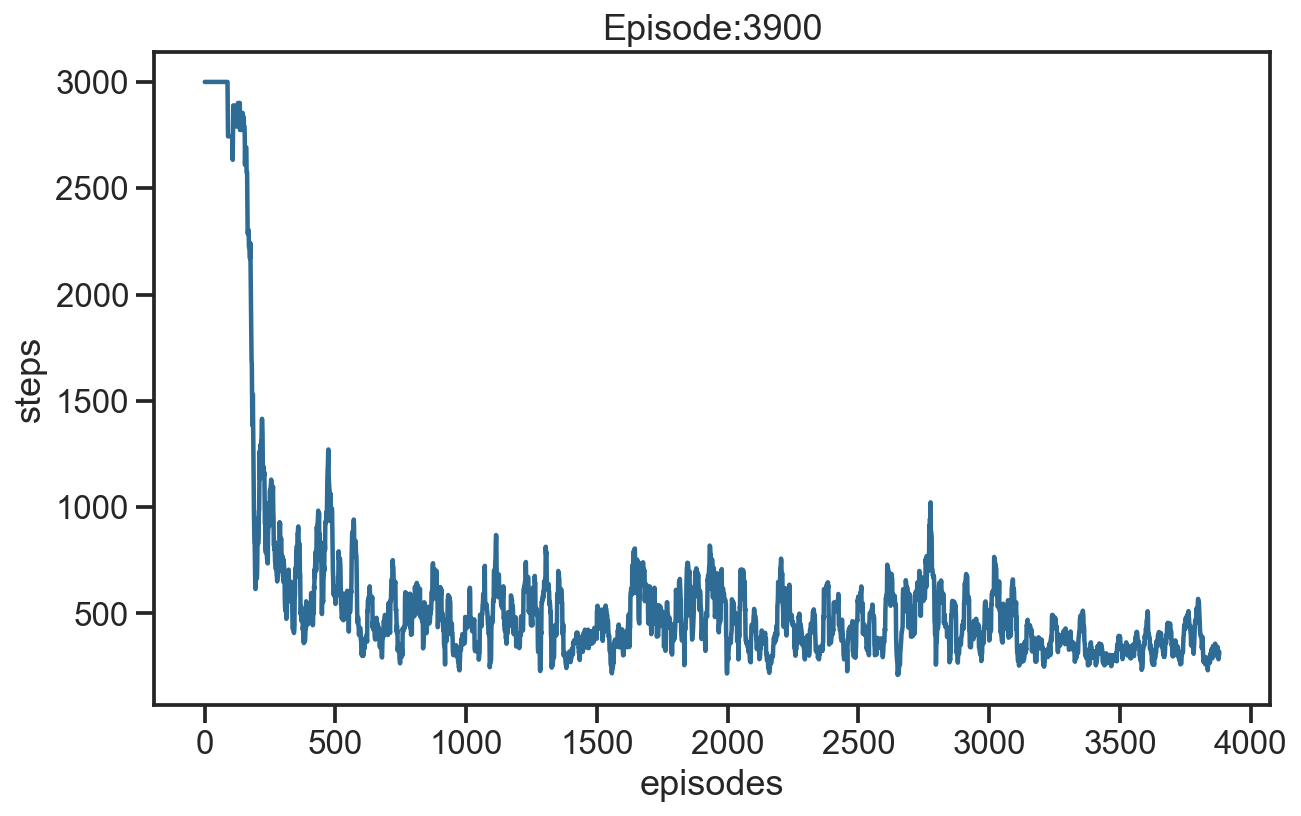

In [230]:
params = [.01, .001, .99, .5] 
Sarsa_lambda_hist, Sarsa_lambda_agent = train(Maze, Sarsa_lambda, params=params, seed=100)

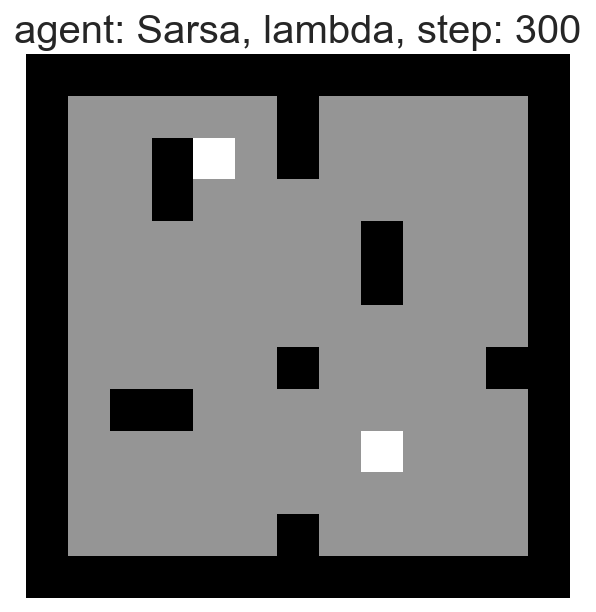

In [231]:
animation(Maze, Sarsa_lambda_agent)